In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Load reference file from UniProt database to find proteins on chrY
fn_ref = '/data100t1/home/wanying/shared_data_files/UniProt/UP000005640_9606_proteome.bed'
df_ref = pd.read_csv(fn_ref, sep='\t', header=None)
display(df_ref.head(2))
print(df_ref[0].unique())
y_proteins = df_ref[df_ref[0]=='chrY'][12].unique()
print('# N proteins on chrY from UniProt database:', len(y_proteins))

# Load phenotype
fn_pheno = '/data100t1/share/CCHC/phenotypes/0724/cchc_phenotypes_0724.txt'
cols_to_use = ['RRID', 'LABID', 'AGE_AT_VISIT', 'GENDER']
df_pheno = pd.read_csv(fn_pheno, sep='|', dtype=str)[cols_to_use]
display(df_pheno.head(2))

# Load ID mapping file (OlinkID to UniProt ID)
fn_id_mapping = '~/CCHC/proteomics/20241014_data_cleaning/output/olink_uniprot_assay_id_mapping.csv'
df_id_mapping = pd.read_csv(fn_id_mapping)
display(df_id_mapping.head(2))

# Create a dictionary to map OlinkID to UniProt ID
df_cchc_y_proteins = df_id_mapping[df_id_mapping['UniProt'].isin(y_proteins)][['OlinkID', 'Assay']]
dict_y_proteins_id_mapping = dict(zip(df_cchc_y_proteins['OlinkID'], df_cchc_y_proteins['Assay']))
print('# N proteins on chrY in CCHC proteomics batch2:', len(df_cchc_y_proteins))
display(df_cchc_y_proteins)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,MT,3306,4262,P03886,0,+,3307,4260,"255,0,0",1,956,0,P03886,M1-T318
1,MT,3306,4262,U5Z754,0,+,3307,4260,"255,0,0",1,956,0,U5Z754,M1-T318


['MT' 'chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16'
 'chr17' 'chr18' 'chr19' 'chr2' 'chr20' 'chr21' 'chr22' 'chr3' 'chr4'
 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chrX' 'chrY']
# N proteins on chrY from UniProt database: 178


,RRID,LABID,AGE_AT_VISIT,GENDER
0,BD0001,BD4001,40.0,2.0
1,BD0001,5Y0002,30.4,2.0


,OlinkID,UniProt,Assay
0,OID45511,EXT1,Extension control 1
1,OID45519,INC1,Incubation control 1


# N proteins on chrY in CCHC proteomics batch2: 12


,OlinkID,Assay
14,OID40012,AMELY
979,OID40984,CDY1
1049,OID41055,CRLF2
1070,OID41078,DAZ1
1317,OID41325,IL9R
1359,OID41367,KDM5D
1779,OID41796,SHOX
1850,OID41868,SRY
2322,OID42348,DAZ4
2595,OID42626,IL3RA


# 1. Missingness

# 2. Sex check

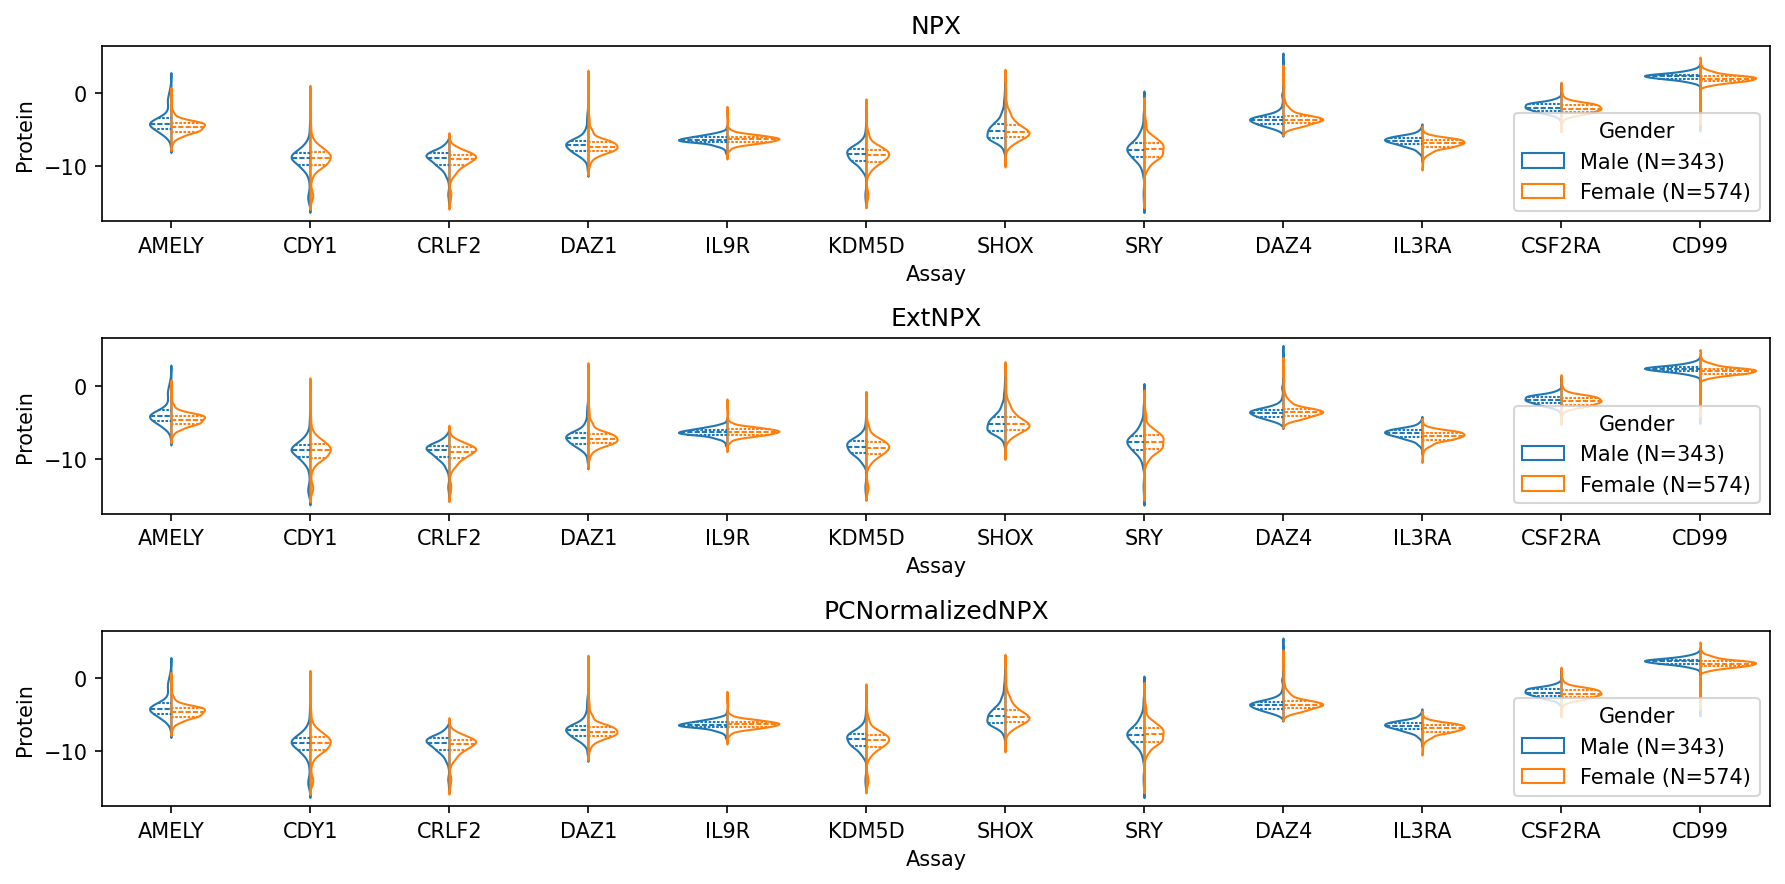

In [105]:
file_path = '~/CCHC/proteomics/20241014_data_cleaning/output'
fig, ax = plt.subplots(nrows=3, figsize=(12,6), dpi=150)
dict_protein_dfs = dict() # Store dataframes of each measure type
for i, data_type in enumerate(['NPX', 'ExtNPX', 'PCNormalizedNPX']):
    fn_protein = '20240919_CCHC_proteomics.batch2.OlinkID.ExtNPX.csv'
    df_protein = pd.read_csv(f'{file_path}/{fn_protein}')
    dict_protein_dfs[data_type] = df_protein
    df_protein_chry = df_protein[['LABID']+list(df_cchc_y_proteins['OlinkID'])]
    # Merge with phenotype to get gender
    df_protein_chry = df_pheno[['LABID','GENDER']].merge(df_protein_chry, on='LABID')
    # Count number of males and females
    n_male = len(df_protein_chry[df_protein_chry['GENDER']=='1.0'])
    n_female = len(df_protein_chry[df_protein_chry['GENDER']=='2.0'])
    df_protein_chry['Gender'] = df_protein_chry['GENDER'].replace('1.0',f'Male (N={n_male})').replace('2.0', f'Female (N={n_female})')
    # Reformat the proteomics dataframe for plotting
    lst_dfs = []
    for olink_id, uniprot_id in dict_y_proteins_id_mapping.items():
        df_single_protein = df_protein_chry[['LABID', 'Gender', olink_id]].copy()
        df_single_protein['Assay'] = uniprot_id
        df_single_protein['OlinkID'] = olink_id
        lst_dfs.append(df_single_protein.rename(columns={olink_id:'Protein'}))
    df_y_proteins_reformat = pd.concat(lst_dfs).reset_index(drop=True)
    output_fn = f'~/CCHC/proteomics/20241014_data_cleaning/output/chrY_proteins.{data_type}.csv'
    df_y_proteins_reformat.to_csv(output_fn, index=False)
    # display(df_y_proteins_reformat.head(2))

    # Plot
    sns.violinplot(data=df_y_proteins_reformat, x='Assay', y='Protein', hue='Gender',
                   split=True, fill=False, inner='quart', ax=ax[i], linewidth=1)
    ax[i].set_title(data_type)
    if data_type=='NPX':
        # Plot untransformed protein concentrations
        # NPX is supposed to be log2 transformed values
        df_untransformed_proteins = df_y_proteins_reformat.copy()
        df_untransformed_proteins['Protein'] = 2**(df_y_proteins_reformat['Protein'])
        # sns.violinplot(data=df_untransformed_proteins, x='Assay', y='Protein',
        #                hue='Gender', split=True, fill=False, inner='quart', ax=ax[-1])
        # ax[-1].set_title('Untransformed protein levels ($2^{NPX}$)', fontsize='large')
    
fig.tight_layout()
fig.savefig('chrY_proteins_in_NPX_entNPX_PCNormalizedNPX.png')

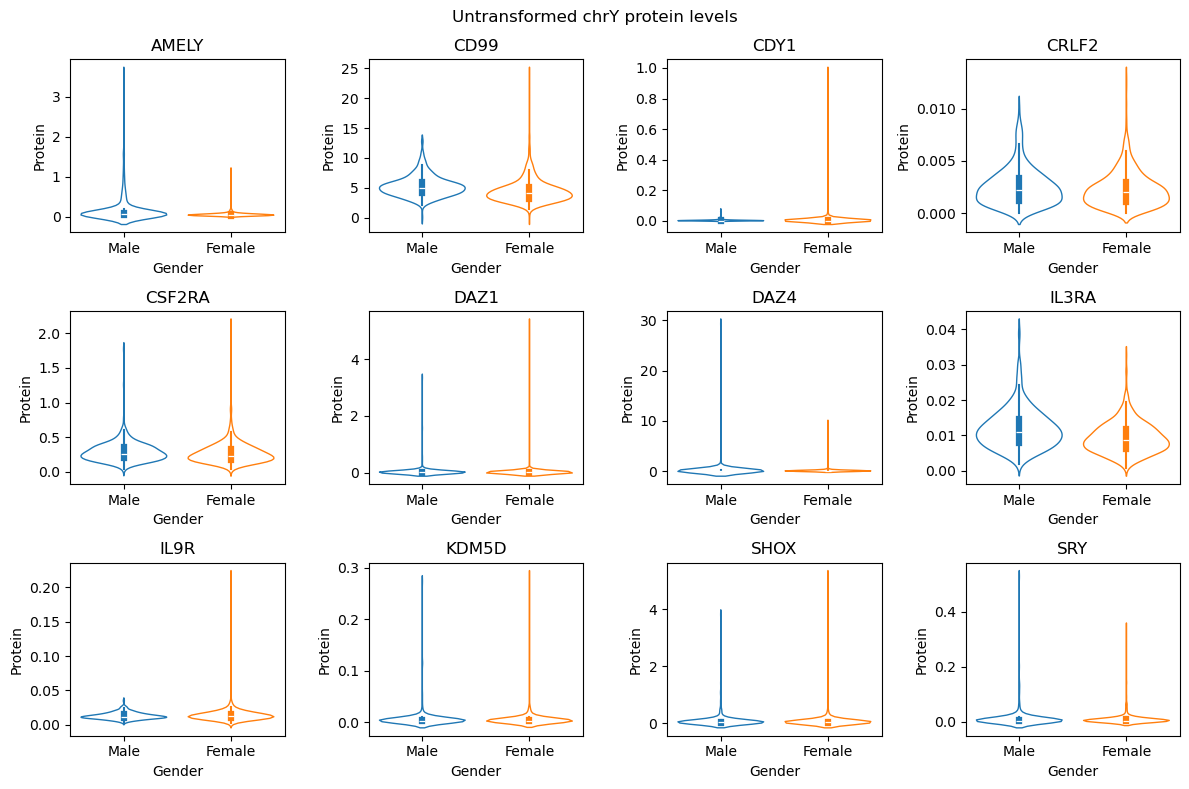

In [123]:
# Plot untransformed protein levels
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
ax = ax.flatten()
for i, (assay, df) in enumerate(df_untransformed_proteins.groupby('Assay')):
    df['Gender'] = df['Gender'].replace('Male (N=343)', 'Male').replace('Female (N=574)', 'Female')
    sns.violinplot(data=df, x='Gender', y='Protein', linewidth=1,
                   fill=False, hue='Gender', ax=ax[i])
    ax[i].set_title(assay)
fig.suptitle('Untransformed chrY protein levels')
fig.tight_layout()
fig.savefig('chrY_proteins_in_untransformed_level.png')

# 3. Normality check